In [53]:
# importing libraries
from os import getcwd, path
from pathlib import Path

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from typing import Set, List

from data_analysis_helper_fun import *

In [54]:
import warnings
warnings.filterwarnings('ignore')

In [55]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

## Loading Data

In [56]:
 # relative path to data directory
data_dir = path.join(Path(getcwd()).parent.absolute(), "data")
data_set_name = 're_data_tau_alpha'
data_file_name = f'{data_set_name}.csv' #.tar.gz'

In [57]:
# working on strings directly in order to avoid having to literal_eval millions of strings

def theory_lengths(x):
    
    # split the list of endpoint tuples 
    l = x.split('), (')

    # split each endpoint tuple into a theory and a commitment position (set representation with {})
    l = [s.split('}, {') for s in l]
     
    # length of the first element (theory) after the comma-separated sentences have been split
    return [len(s[0].split(',')) for s in l]
    

In [58]:

re_data = load_re_data(data_dir, 
                                data_file_name,
                                usecols = ["model_name",
                                           'n_sentence_pool',
                                           "ds",
                                           "init_coms",
                                           'weight_account', 
                                           'weight_systematicity',
                                           "n_fixed_points",
                                           'fp_account', 
                                           'fp_faithfulness',
                                           "n_global_optima",
                                           'go_account', 
                                           'go_faithfulness',
                                           'error_code',
                                           'fixed_points',
                                           'global_optima'
                                           ],
                               evalcols = ['fp_account', 
                                           'fp_faithfulness',
                                           'go_account',
                                           'go_faithfulness',
                                           #'fixed_points',
                                            #'global_optima'
                                          ],
                      filter_erroneous_runs = True)

In [59]:
# useful, if filter_erroneous_runs = False

print(f"The data set contains {sum(re_data['error_code'].isna()==False)}/{len(re_data)} rows of erroneous model runs.")
# filter
re_data = re_data.loc[re_data['error_code'].isna()]

The data set contains 0/4136547 rows of erroneous model runs.


In [60]:
# output directory
tables_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "tables")
figures_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "figures")

In [61]:
print('\033[1m' + 'General information: ' + '\033[0m')
print("   Amount of rows:" , len(re_data))
print('   Number of dialectical structures:', len(re_data['ds'].unique()))
print('   Overall number of initial commitments:', len(re_data['init_coms'].unique()))
print('   Sentence-pools:' , re_data['n_sentence_pool'].unique())
print('   Models:' , re_data['model_name'].unique())
print('\n')

General information: 
   Amount of rows: 4136547
   Number of dialectical structures: 200
   Overall number of initial commitments: 80
   Sentence-pools: [6 7 8 9]
   Models: ['QuadraticGlobalRE' 'LinearGlobalRE' 'QuadraticLocalRE' 'LinearLocalRE']




In [62]:
re_data.columns

Index(['model_name', 'ds', 'n_sentence_pool', 'weight_account',
       'weight_systematicity', 'init_coms', 'error_code', 'fixed_points',
       'n_fixed_points', 'fp_account', 'fp_faithfulness', 'global_optima',
       'n_global_optima', 'go_account', 'go_faithfulness', 'model_short_name'],
      dtype='object')

## Setup Dataframes

In [63]:
""" 
If `analyse_branches` is set to `true`, all branches of RE processes are considered for the analysis. 
This may lead to the multiple counting of a unique fixed point, 
if they are reached on different paths from a simulation setup.
Otherwise, the subsequent analysis comprises only unique fixed points per simulation setups
"""

# Currently, no information concerning account/faithfulness values is stored in branches.
analyse_branches = False 

"""Whether bootstrapping is applied to estimate mean and standard deviation"""
bootstrap = True
n_resamples = 400


grouping = ["model_name"]

# Whether resulting tables and figures are exported to the corresponing output directory"""
export_results = True

In [64]:
# the analysis of global optima is not affected by status of `analyse_branches`

# restrict data to unique simulation setups to prevent multiple counting of branches 
re_data_unique_setups = re_data.drop_duplicates(["model_name",
                         "ds",
                         "n_sentence_pool",
                         'weight_account', 
                         'weight_systematicity', 
                         'init_coms'
                        ])

In [69]:
# restrict to relevant columns
go_data = re_data_unique_setups[["model_name",
                                 "ds",
                                 "init_coms",
                                 "weight_account", 
                                 "weight_systematicity",
                                 "global_optima",
                                 'go_account', 
                                 'go_faithfulness'
                                ]]

In [70]:
# add lengths of global optima theories

go_data["go_theory_len"] = go_data["global_optima"].apply(theory_lengths)

In [71]:
# remove global_optima column
go_data = go_data[["model_name",
            "ds",
            "init_coms",
            "weight_account", 
            "weight_systematicity",
            #"global_optima",
            'go_account', 
            'go_faithfulness',
            "go_theory_len"
            ]]

In [72]:
# explode information about global optima, which is stored rowwise (per simulation setup) 
# in lists (e.g. in the column `go_full_re_state`)
exploded_go_data = go_data.set_index(["model_name",
                                      "ds",
                                      "init_coms",
                                      "weight_account", 
                                      "weight_systematicity",
                                     ]).apply(pd.Series.explode).reset_index()

exploded_go_data.shape

(2845799, 8)

In [73]:
# add lengths of global optima theories
#exploded_go_data["go_theory_len"] = exploded_go_data["global_optima"].apply(lambda x: len(x[0]))

# add bools for max values
exploded_go_data["max_go_account"] = exploded_go_data["go_account"]==1
exploded_go_data["max_go_systematicity"] = exploded_go_data["go_theory_len"]==1
exploded_go_data["max_go_faithfulness"] = exploded_go_data["go_faithfulness"]==1

In [74]:
re_data_unique_setups.groupby("model_name")["ds"].size()

model_name
LinearGlobalRE       143973
LinearLocalRE        142219
QuadraticGlobalRE    143964
QuadraticLocalRE     143079
Name: ds, dtype: int64

In [75]:
if analyse_branches:
    
    raise ValueError("`analyse_branches` cannot be set to `true`")
    # use all rows and restrict to relevant columns
    #fp_data = re_data[["model_name",
    #                   "ds",
    #                   "init_coms",
    #                   "weight_account", 
    #                   "weight_systematicity", 
    #                   'fixed_point_is_full_re_state']]
    #
    ## rename fixed point columns 
    ## note: df is already exploded
    #exploded_fp_data = fp_data.rename(columns={'fixed_point_is_full_re_state': "fp_full_re_state",})
    
else:
    
    # use unique setups and restrict to relevant columns
    fp_data = re_data_unique_setups[["model_name",
                                     "ds",
                                     "init_coms",
                                     "weight_account", 
                                     "weight_systematicity",
                                     "fixed_points",
                                     'fp_account', 
                                     'fp_faithfulness',
                                    ]]
    
    # add lengths of fixed points theories
    fp_data["fp_theory_len"] = fp_data["fixed_points"].apply(theory_lengths)
    
    # remove fixed_points column
    fp_data = fp_data[["model_name",
                       "ds",
                       "init_coms",
                       "weight_account", 
                       "weight_systematicity",
                       #"fixed_points",
                       'fp_account', 
                       'fp_faithfulness',
                       'fp_theory_len'
                                    ]]
    
    # explode information about unique fixed points, which is stored rowwise (per simulation setup) 
    # in lists (e.g. in the column `fp_full_re_state`) 
    exploded_fp_data = fp_data.set_index(["model_name",
                                          "ds",
                                          "init_coms",
                                          "weight_account", 
                                          "weight_systematicity"]).apply(pd.Series.explode).reset_index()
    
exploded_fp_data.shape

(1587288, 8)

In [76]:
# add lengths of fixed points theories
#exploded_fp_data["fp_theory_len"] = exploded_fp_data["fixed_points"].apply(lambda x: len(x[0]))


# add bools for max values
exploded_fp_data["max_fp_account"] = exploded_fp_data["fp_account"]==1
exploded_fp_data["max_fp_systematicity"] = exploded_fp_data["fp_theory_len"]==1
exploded_fp_data["max_fp_faithfulness"] = exploded_fp_data["fp_faithfulness"]==1

In [77]:
#for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):
#
#    fig = make_subplots(rows=2, cols=2,
#                        shared_xaxes=True,
#                        #shared_yaxes=True,
#                        vertical_spacing=0.12,
#                        subplot_titles=(model_names))
#
#    for model_name, pos in zip(model_names, [(1,1), (1,2), (2,1), (2,2)]):
#
#        g_df = df[df["model_name"]==model_name]
#
#        # Note: init_coms is used as a dummy column for counting
#        g_df = g_df.groupby("{}_account".format(endpoint_type))["init_coms"].size().reset_index()
#
#        fig.add_trace(go.Bar(x=g_df["{}_account".format(endpoint_type)], 
#                             y=g_df["init_coms"],
#                             marker_color=viridis_map[model_name]), 
#                      row=pos[0], 
#                      col=pos[1])
#
#    fig.update_xaxes(title_text="Account", row=2, col=1)
#    fig.update_xaxes(title_text="Account", row=2, col=2)
#    
#    fig.update_xaxes(range=[0.0, 1.0])
#
#    fig.update_yaxes(title_text="Number", row=1, col=1)
#    fig.update_yaxes(title_text="Number", row=2, col=1)
#
#    fig.update_annotations(font_size=12)
#    fig.update_yaxes(title_font=dict(size=12))
#    fig.update_xaxes(title_font=dict(size=12))
#    
#    endpoint = "global optima" if endpoint_type == "go" else "fixed points"
#    fig_title = "Number of {} achieving specific account measure values".format(endpoint)
#    
#    fig.update_layout(template="plotly_white",
#                      showlegend=False,
#                      title=fig_title)
#
#    fig.show()

In [78]:
#for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):
#
#    fig = make_subplots(rows=2, cols=2,
#                        shared_xaxes=True,
#                        #shared_yaxes=True,
#                        vertical_spacing=0.12,
#                        subplot_titles=(model_names))
#
#    for model_name, pos in zip(model_names, [(1,1), (1,2), (2,1), (2,2)]):
#
#        g_df = df[df["model_name"]==model_name]
#
#        # Note: init_coms is used as a dummy column for counting
#        g_df = g_df.groupby("{}_faithfulness".format(endpoint_type))["init_coms"].size().reset_index()
#
#        fig.add_trace(go.Bar(x=g_df["{}_faithfulness".format(endpoint_type)], 
#                             y=g_df["init_coms"],
#                             marker_color=viridis_map[model_name]), 
#                      row=pos[0], 
#                      col=pos[1])
#
#    fig.update_xaxes(title_text="Faithfulness", row=2, col=1)
#    fig.update_xaxes(title_text="Faithfulness", row=2, col=2)
#    
#    fig.update_xaxes(range=[0.0, 1.0])
#
#    fig.update_yaxes(title_text="Number", row=1, col=1)
#    fig.update_yaxes(title_text="Number", row=2, col=1)
#
#    fig.update_annotations(font_size=12)
#    fig.update_yaxes(title_font=dict(size=12))
#    fig.update_xaxes(title_font=dict(size=12))
#    
#    endpoint = "global optima" if endpoint_type == "go" else "fixed points"
#    fig_title = "Number of {} achieving specific faithfulness measure values".format(endpoint)
#    
#    fig.update_layout(template="plotly_white",
#                      showlegend=False,
#                      title=fig_title)
#
#    fig.show()

## Tables

### Maximal values

In [79]:
#grouping = ["model_name"]

In [80]:
## number of global optima with account = 1
#df1 = exploded_go_data[exploded_go_data["go_account"]==1].groupby(grouping)["go_account"].size().reset_index()
#df1.rename(columns={"go_account":"n_go_max_account"}, inplace=True)
#
## number of global optima with systematicity = 1
#df2 = exploded_go_data[exploded_go_data["go_theory_len"]==1].groupby(grouping)["go_theory_len"].size().reset_index()
#df2.rename(columns={"go_theory_len":"n_go_max_systematicity"}, inplace=True)
#
## number of global optima with faithfulness = 1
#df3 = exploded_go_data[exploded_go_data["go_faithfulness"]==1].groupby(grouping)["go_faithfulness"].size().reset_index()
#df3.rename(columns={"go_faithfulness":"n_go_max_faithfulness"}, inplace=True)
#
## number of global optima
#df4 = exploded_go_data.groupby(grouping)["go_account"].size().reset_index()
#df4.rename(columns={"go_account":"n_global_optima"}, inplace=True)
#
#go_df = df1.join(df2.set_index("model_name"), on="model_name")
#go_df = go_df.join(df3.set_index("model_name"), on="model_name")
#go_df = go_df.join(df4.set_index("model_name"), on="model_name")
#
#go_df["rel_go_max_account"] = go_df["n_go_max_account"]/go_df["n_global_optima"]
#go_df["rel_go_max_systematicity"] = go_df["n_go_max_systematicity"]/go_df["n_global_optima"]
#go_df["rel_go_max_faithfulness"] = go_df["n_go_max_faithfulness"]/go_df["n_global_optima"]
#
#go_df

In [81]:
# separate tables for go and fp

for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):
    
    result_df = None
    
    for measure in ['account', 'systematicity', 'faithfulness']:
    
        new_result_df = rel_share_of_property(df, 
                               "max_{}_{}".format(endpoint_type, measure), 
                                col_rename = None,
                                groupby_cols=['model_name'],
                                collapse_branches=False,
                                cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'],
                                explode_cols=None,
                                bootstrap=bootstrap, 
                                n_resamples=n_resamples)

        new_result_df.reset_index(inplace=True)
        
        if result_df is None:
            result_df = new_result_df
        else:
            result_df = result_df.join(new_result_df.set_index("model_name"), on="model_name")
            
    # for later use
    if endpoint_type == "go":
        go_result_df = result_df
    else:
        fp_result_df = result_df
    
    # sort by model name
    result_df['model_name'] = pd.Categorical(result_df['model_name'], ["QuadraticGlobalRE", 
                                                                       "LinearGlobalRE", 
                                                                       "QuadraticLocalRE", 
                                                                       "LinearLocalRE"])
    result_df.sort_values("model_name", inplace=True)
    
    
    
    # Changing col names for readability
    cols_for_tables = {'model_name':'Model',
                       'sum_max_fp_account': 'Number of fixed points with maximal account',
                       'sum_max_fp_systematicity': 'Number of fixed points with maximal systematicity',
                       'sum_max_fp_faithfulness': 'Number of fixed points with maximal faithfulness',
                       'size_max_fp_account': 'Number of fixed points',
                       'rel_max_fp_account': 'Relative share of fixed points with maximal account',
                       'rel_max_fp_systematicity': 'Relative share of fixed points with maximal systematicity',
                       'rel_max_fp_faithfulness': 'Relative share of fixed points with maximal faithfulness',
                       'sum_max_go_account': 'Number of global optima with maximal account',
                       'sum_max_go_systematicity': 'Number of global optima with maximal systematicity',
                       'sum_max_go_faithfulness': 'Number of global optima with maximal faithfulness', 
                       'size_max_go_account': 'Number of global optima',
                       'rel_max_go_account': 'Relative share of global optima with maximal account',
                       'rel_max_go_systematicity': 'Relative share of global optima with maximal systematicity',
                       'rel_max_go_faithfulness': 'Relative share of global optima with maximal faithfulness',
                       'std_max_go_account': 'Standard deviation account',
                       'std_max_go_systematicity': 'Standard deviation systematicity',
                       'std_max_go_faithfulness': 'Standard deviation faithfulness',
                       'std_max_fp_account': 'Standard deviation account',
                       'std_max_fp_systematicity': 'Standard deviation systematicity',
                       'std_max_fp_faithfulness': 'Standard deviation faithfulness',
                  }
    renamed_result_df = result_df.rename(columns=cols_for_tables)
    
    # restrict to most relevant columns
    retain_columns = [col for col in renamed_result_df.columns if (("size" not in col) and ("sum" not in col))]
    
    renamed_result_df = renamed_result_df[retain_columns]

    display(renamed_result_df)
    
    # Exporting relevant cols
    if export_results:
        file_name = 'table_max_values_{}_{}.csv'.format(endpoint_type, 'branches' if analyse_branches else 'setups')
        renamed_result_df.to_csv(path.join(tables_output_dir, file_name), index=False)
    
    
    
    

Model  Relative share of global optima with maximal account  \
2  QuadraticGlobalRE                                           0.115197      
0     LinearGlobalRE                                           0.274773      
3   QuadraticLocalRE                                           0.115262      
1      LinearLocalRE                                           0.254990      

   Standard deviation account  Number of global optima with maximal account  \
2                    0.000380                                         82318   
0                    0.000524                                        192559   
3                    0.000369                                         81750   
1                    0.000487                                        183875   

   Number of global optima  \
2                   714584   
0                   700830   
3                   709289   
1                   721096   

   Relative share of global optima with maximal systematicity  \
2                                           0.726954            
0                                           0.875100            
3                                           0.728928            
1                                           0.880079            

   Standard deviation systematicity  \
2                          0.000539   
0                          0.000396   
3                          0.000543   
1                          0.000366   

   Number of global optima with maximal systematicity  \
2                                             519496    
0                                             613282    
3                                             517054    
1                                             634625    

   Relative share of global optima with maximal faithfulness  \
2                                           0.114941           
0                                           0.287649           
3                                           0.115665           
1                                           0.279361           

   Standard deviation faithfulness  \
2                         0.000405   
0                         0.000563   
3                         0.000407   
1                         0.000515   

   Number of global optima with maximal faithfulness  
2                                              82133  
0                                             201631  
3                                              82043  
1                                             201469

Model  Relative share of fixed points with maximal account  \
2  QuadraticGlobalRE                                           0.165704     
0     LinearGlobalRE                                           0.382203     
3   QuadraticLocalRE                                           0.138413     
1      LinearLocalRE                                           0.639384     

   Standard deviation account  Number of fixed points with maximal account  \
2                    0.000563                                        75903   
0                    0.000889                                       119569   
3                    0.000442                                        81396   
1                    0.001008                                       145846   

   Number of fixed points  \
2                  458147   
0                  312783   
3                  588236   
1                  228122   

   Relative share of fixed points with maximal systematicity  \
2                                           0.582246           
0                                           0.724166           
3                                           0.494846           
1                                           0.502550           

   Standard deviation systematicity  \
2                          0.000757   
0                          0.000794   
3                          0.000672   
1                          0.001027   

   Number of fixed points with maximal systematicity  \
2                                             266761   
0                                             226486   
3                                             291113   
1                                             114636   

   Relative share of fixed points with maximal faithfulness  \
2                                           0.198948          
0                                           0.572917          
3                                           0.083458          
1                                           0.357047          

   Standard deviation faithfulness  \
2                         0.000598   
0                         0.000910   
3                         0.000354   
1                         0.000987   

   Number of fixed points with maximal faithfulness  
2                                             91150  
0                                            179208  
3                                             49095  
1                                             81451

In [82]:
## number of fixed points with account = 1
#df1 = exploded_fp_data[exploded_fp_data["fp_account"]==1].groupby(grouping)["fp_account"].size().reset_index()
#df1.rename(columns={"fp_account":"n_fp_max_account"}, inplace=True)
#
## number of fixed points with systematicity = 1
#df2 = exploded_fp_data[exploded_fp_data["fp_theory_len"]==1].groupby(grouping)["fp_theory_len"].size().reset_index()
#df2.rename(columns={"fp_theory_len":"n_fp_max_systematicity"}, inplace=True)
#
## number of fixed points with faithfulness = 1
#df3 = exploded_fp_data[exploded_fp_data["fp_faithfulness"]==1].groupby(grouping)["fp_faithfulness"].size().reset_index()
#df3.rename(columns={"fp_faithfulness":"n_fp_max_faithfulness"}, inplace=True)
#
## number of fixed points
#df4 = exploded_fp_data.groupby(grouping)["fp_account"].size().reset_index()
#df4.rename(columns={"fp_account":"n_fixed_points"}, inplace=True)
#
#
#
#fp_df = df1.join(df2.set_index("model_name"), on="model_name")
#fp_df = fp_df.join(df3.set_index("model_name"), on="model_name")
#fp_df = fp_df.join(df4.set_index("model_name"), on="model_name")
#
#
#fp_df["rel_fp_max_account"] = fp_df["n_fp_max_account"]/fp_df["n_fixed_points"]
#fp_df["rel_fp_max_systematicity"] = fp_df["n_fp_max_systematicity"]/fp_df["n_fixed_points"]
#fp_df["rel_fp_max_faithfulness"] = fp_df["n_fp_max_faithfulness"]/fp_df["n_fixed_points"]
#
#fp_df

In [83]:
## separate tables for go and fp
#
#for df, endpoint_type in zip([go_df, fp_df], ["go", "fp"]):
#    
#    # sort by model name
#    df['model_name'] = pd.Categorical(df['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
#    df.sort_values("model_name", inplace=True)
#    
#    # Changing col names for readability
#    cols_for_tables = {'model_name':'Model',
#                       'n_fp_max_account': 'Number of fixed points with maximal account',
#                       'n_fp_max_systematicity': 'Number of fixed points with maximal systematicity',
#                       'n_fp_max_faithfulness': 'Number of fixed points with maximal faithfulness',
#                       'n_fixed_points': 'Number of fixed points',
#                       'rel_fp_max_account': 'Relative share of fixed points with maximal account',
#                       'rel_fp_max_systematicity': 'Relative share of fixed points with maximal systematicity',
#                       'rel_fp_max_faithfulness': 'Relative share of fixed points with maximal faithfulness',
#                       'n_go_max_account': 'Number of global optima with maximal account',
#                       'n_go_max_systematicity': 'Number of global optima with maximal systematicity',
#                       'n_go_max_faithfulness': 'Number of global optima with maximal faithfulness', 
#                       'n_global_optima': 'Number of global optima',
#                       'rel_go_max_account': 'Relative share of global optima with maximal account',
#                       'rel_go_max_systematicity': 'Relative share of global optima with maximal systematicity',
#                       'rel_go_max_faithfulness': 'Relative share of global optima with maximal faithfulness'
#                  }
#
#    display(df.rename(columns=cols_for_tables))
#    
#    
#    # Exporting relevant cols
#    if export_results:
#        file_name = 'table_max_values_{}_{}.csv'.format(endpoint_type, 'branches' if analyse_branches else 'setups')
#        df.rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, file_name), index=False)
#    

### Minimal values

In [84]:
# number of global optima with account = 0
df1 = exploded_go_data[exploded_go_data["go_account"]==0].groupby(grouping)["go_account"].size().reset_index()
df1.rename(columns={"go_account":"n_go_min_account"}, inplace=True)
df1

Empty DataFrame
Columns: [model_name, n_go_min_account]
Index: []

In [85]:
# number of global optima with systematicity = 0
df2 = exploded_go_data[exploded_go_data["go_theory_len"]==0].groupby(grouping)["go_theory_len"].size().reset_index()
df2.rename(columns={"go_theory_len":"n_go_max_systematicity"}, inplace=True)
df2

Empty DataFrame
Columns: [model_name, n_go_max_systematicity]
Index: []

In [86]:
# number of global optima with faithfulness = 0
df3 = exploded_go_data[exploded_go_data["go_faithfulness"]==0].groupby(grouping)["go_faithfulness"].size().reset_index()
df3.rename(columns={"go_faithfulness":"n_go_min_faithfulness"}, inplace=True)
df3

Empty DataFrame
Columns: [model_name, n_go_min_faithfulness]
Index: []

In [87]:
# number of fixed points with account = 0
df1 = exploded_fp_data[exploded_fp_data["fp_account"]==0].groupby(grouping)["fp_account"].size().reset_index()
df1.rename(columns={"fp_account":"n_fp_min_account"}, inplace=True)
df1

Empty DataFrame
Columns: [model_name, n_fp_min_account]
Index: []

In [88]:
# number of fixed points with systematicity = 0
df2 = exploded_fp_data[exploded_fp_data["fp_theory_len"]==0].groupby(grouping)["fp_theory_len"].size().reset_index()
df2.rename(columns={"fp_theory_len":"n_fp_max_systematicity"}, inplace=True)
df2

Empty DataFrame
Columns: [model_name, n_fp_max_systematicity]
Index: []

In [89]:
# number of fixed points with faithfulness = 0
df3 = exploded_fp_data[exploded_fp_data["fp_faithfulness"]==0].groupby(grouping)["fp_faithfulness"].size().reset_index()
df3.rename(columns={"fp_faithfulness":"n_fp_min_faithfulness"}, inplace=True)
df3

Empty DataFrame
Columns: [model_name, n_fp_min_faithfulness]
Index: []

## Plots

In [90]:
model_names = ['QuadraticGlobalRE',
               'LinearGlobalRE',
               'QuadraticLocalRE',
               'LinearLocalRE',]

# color palette
viridis = ["#472c7a", "#2c718e", "#29ae80", "#b0dd31"]
viridis_map = {}
for model_name, color in zip(model_names, viridis):
    viridis_map[model_name] = color

### Barplots

In [91]:
for df, endpoint_type in zip([fp_result_df, go_result_df], ['fp', 'go']):
    
    fig = make_subplots(rows=1, 
                        cols=4,
                        shared_yaxes=True)
    
    for i, model_name in enumerate(model_names):
        
        rdf = df[df["model_name"]==model_name]
        
        x_arr = ["$A$", "$S$", "$F$"]
        
        y_arr = rdf[["rel_max_{}_account".format(endpoint_type),
                     "rel_max_{}_systematicity".format(endpoint_type),
                     "rel_max_{}_faithfulness".format(endpoint_type)
                                  ]].round(3).to_numpy()
        
        fig.add_trace(go.Bar(x=x_arr, 
                             y=y_arr[0],
                             marker_color=viridis_map[model_name],
                             text=y_arr[0]), 
                      row=1, 
                      col=i+1)
        
        fig.update_xaxes(title=model_name, 
                         showticklabels=True, 
                         showgrid=False, 
                         linecolor= 'DarkGrey', 
                         row=1, 
                         col=i+1)
        
    fig.update_layout(showlegend=False)
    
    fig.update_yaxes(range=[0.0, 1.0])
    
    fig.update_yaxes(title="Relative share", 
                     ticks="outside", 
                     tickcolor="DarkGrey", 
                     #showgrid=False, 
                     linecolor='DarkGrey', 
                     zeroline=True, 
                     zerolinecolor="DarkGrey",
                     zerolinewidth=1, 
                     row=1, 
                     col=1)
    
    
    fig.update_layout(template="plotly_white",
                       #paper_bgcolor="#e9e8e6",
                       #plot_bgcolor="#e9e8e6",
                       font={"color": "black", "size":12},
                       #width=900,
                       margin={"t":80}
                      )

    
    
    fig.update_layout(legend_title_text="")
    
    endpoints = "global optima" if endpoint_type=="go" else "fixed points"
    
    if (endpoint_type == "fp") & (analyse_branches):
        endpoints += " (all branches)"
    
    fig.update_layout(title_text="Relative share of {} maximizing desiderata measures".format(endpoints))

    fig.show()
    
    if export_results:
        file_name = 'overall_max_values_{}_{}.png'.format(endpoint_type, 'branches' if analyse_branches else 'setups')
        fig.write_image(path.join(figures_output_dir, file_name), scale=2)
        
        file_name = 'overall_max_values_{}_{}.pdf'.format(endpoint_type, 'branches' if analyse_branches else 'setups')
        fig.write_image(path.join(figures_output_dir, file_name), scale=2)

### Heatmaps

In [92]:
#new_grouping = ['model_name', 'weight_account','weight_systematicity']

In [93]:
## number of global optima with account = 1
#wdf1 = exploded_go_data[exploded_go_data["go_account"]==1].groupby(new_grouping)["go_account"].size().reset_index()
#wdf1.rename(columns={"go_account":"n_go_max_account"}, inplace=True)
#
## number of global optima with systematicity = 1
#wdf2 = exploded_go_data[exploded_go_data["go_theory_len"]==1].groupby(new_grouping)["go_theory_len"].size().reset_index()
#wdf2.rename(columns={"go_theory_len":"n_go_max_systematicity"}, inplace=True)
#
## number of global optima with faithfulness = 1
#wdf3 = exploded_go_data[exploded_go_data["go_faithfulness"]==1].groupby(new_grouping)["go_faithfulness"].size().reset_index()
#wdf3.rename(columns={"go_faithfulness":"n_go_max_faithfulness"}, inplace=True)
#
## number of global optima
#wdf4 = exploded_go_data.groupby(new_grouping)["go_account"].size().reset_index()
#wdf4.rename(columns={"go_account":"n_global_optima"}, inplace=True)
#
#wgo_df = wdf1.join(wdf2.set_index(new_grouping), on=new_grouping)
#wgo_df = wgo_df.join(wdf3.set_index(new_grouping), on=new_grouping)
#wgo_df = wgo_df.join(wdf4.set_index(new_grouping), on=new_grouping)
#
#wgo_df["rel_go_max_account"] = wgo_df["n_go_max_account"]/wgo_df["n_global_optima"]
#wgo_df["rel_go_max_systematicity"] = wgo_df["n_go_max_systematicity"]/wgo_df["n_global_optima"]
#wgo_df["rel_go_max_faithfulness"] = wgo_df["n_go_max_faithfulness"]/wgo_df["n_global_optima"]
#
#wgo_df["rel_go_max_account"] = wgo_df["rel_go_max_account"].astype(float).round(2)
#wgo_df["rel_go_max_systematicity"] = wgo_df["rel_go_max_systematicity"].astype(float).round(2)
#wgo_df["rel_go_max_faithfulness"] = wgo_df["rel_go_max_faithfulness"].astype(float).round(2)
#
## sort by model name
#wgo_df['model_name'] = pd.Categorical(wgo_df['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
#wgo_df.sort_values("model_name", inplace=True)
#
#wgo_df

In [94]:
## number of fixed points with account = 1
#wdf1 = exploded_fp_data[exploded_fp_data["fp_account"]==1].groupby(new_grouping)["fp_account"].size().reset_index()
#wdf1.rename(columns={"fp_account":"n_fp_max_account"}, inplace=True)
#
## number of fixed points with systematicity = 1
#wdf2 = exploded_fp_data[exploded_fp_data["fp_theory_len"]==1].groupby(new_grouping)["fp_theory_len"].size().reset_index()
#wdf2.rename(columns={"fp_theory_len":"n_fp_max_systematicity"}, inplace=True)
#
## number of fixed points with faithfulness = 1
#wdf3 = exploded_fp_data[exploded_fp_data["fp_faithfulness"]==1].groupby(new_grouping)["fp_faithfulness"].size().reset_index()
#wdf3.rename(columns={"fp_faithfulness":"n_fp_max_faithfulness"}, inplace=True)
#
## number of fixed points
#wdf4 = exploded_fp_data.groupby(new_grouping)["fp_account"].size().reset_index()
#wdf4.rename(columns={"fp_account":"n_fixed_points"}, inplace=True)
#
#
#
#wfp_df = wdf1.join(wdf2.set_index(new_grouping), on=new_grouping)
#wfp_df = wfp_df.join(wdf3.set_index(new_grouping), on=new_grouping)
#wfp_df = wfp_df.join(wdf4.set_index(new_grouping), on=new_grouping)
#
#
#wfp_df["rel_fp_max_account"] = wfp_df["n_fp_max_account"]/wfp_df["n_fixed_points"]
#wfp_df["rel_fp_max_systematicity"] = wfp_df["n_fp_max_systematicity"]/wfp_df["n_fixed_points"]
#wfp_df["rel_fp_max_faithfulness"] = wfp_df["n_fp_max_faithfulness"]/wfp_df["n_fixed_points"]
#
#wfp_df["rel_fp_max_account"] = wfp_df["rel_fp_max_account"].astype(float).round(2)
#wfp_df["rel_fp_max_systematicity"] = wfp_df["rel_fp_max_systematicity"].astype(float).round(2)
#wfp_df["rel_fp_max_faithfulness"] = wfp_df["rel_fp_max_faithfulness"].astype(float).round(2)
#
## sort by model name
#wfp_df['model_name'] = pd.Categorical(wfp_df['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
#wfp_df.sort_values("model_name", inplace=True)
#
#wfp_df

In [95]:
from itertools import product

In [96]:
#for measure, endpoint_type in product(["account", "systematicity", "faithfulness"], ["fp", "go"]):
#    
#    df = wgo_df if endpoint_type == "go" else wfp_df
#    endpoint = "global optima" if endpoint_type == "go" else "fixed points"
#
#    normalized_heat_maps_by_weights(df, 
#                                    "rel_{}_max_{}".format(endpoint_type, measure), 
#                                    "Relative share of {} with maximal {}".format(endpoint, measure),
#                                    annot_std = False,
#                                    #annot_fmt="{:2.2f}\n"
#                                   )
#
#    branches = "branches" if analyse_branches else "setups"
#
#    if export_results:
#        plt.savefig(path.join(figures_output_dir, 'rel_{}_max_{}_{}.png'.format(endpoint_type, measure, branches)), bbox_inches='tight')

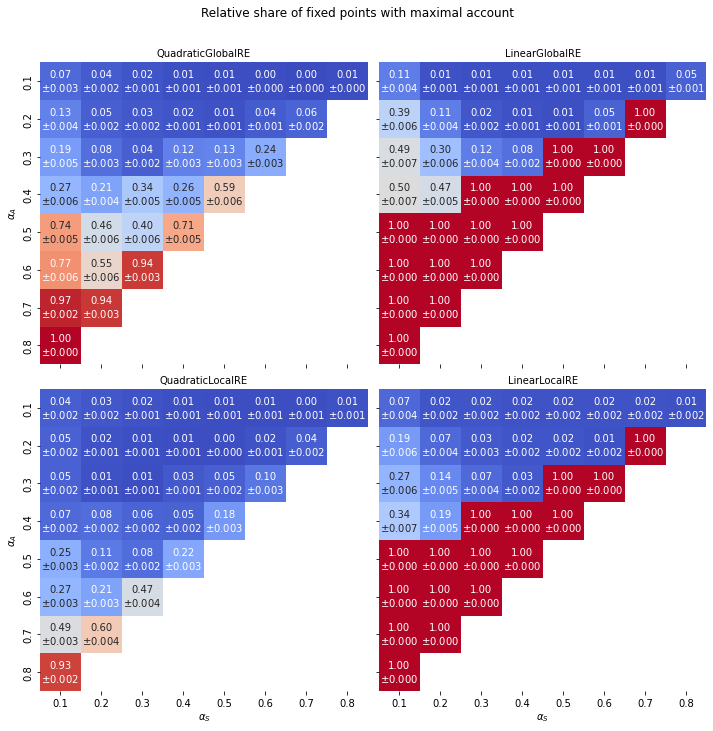

<Figure size 432x288 with 0 Axes>

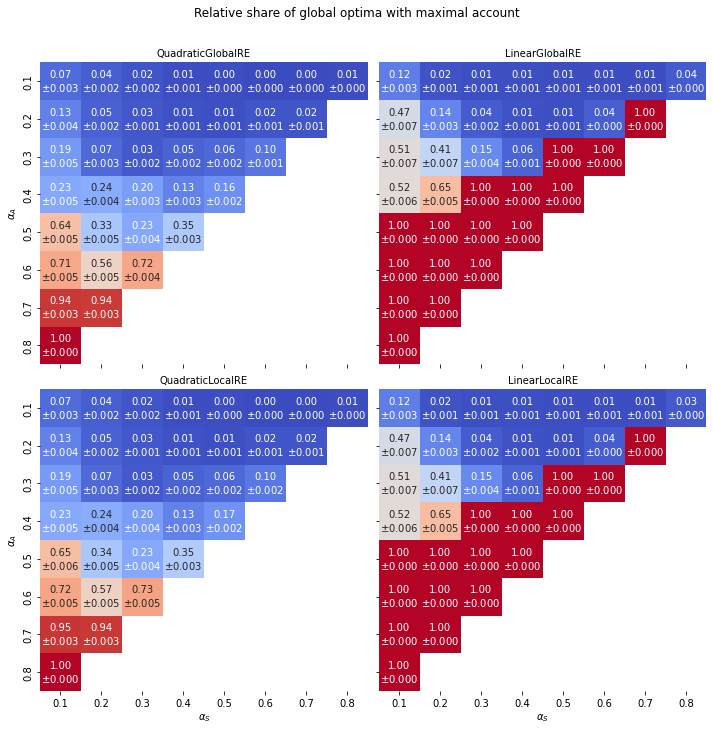

<Figure size 432x288 with 0 Axes>

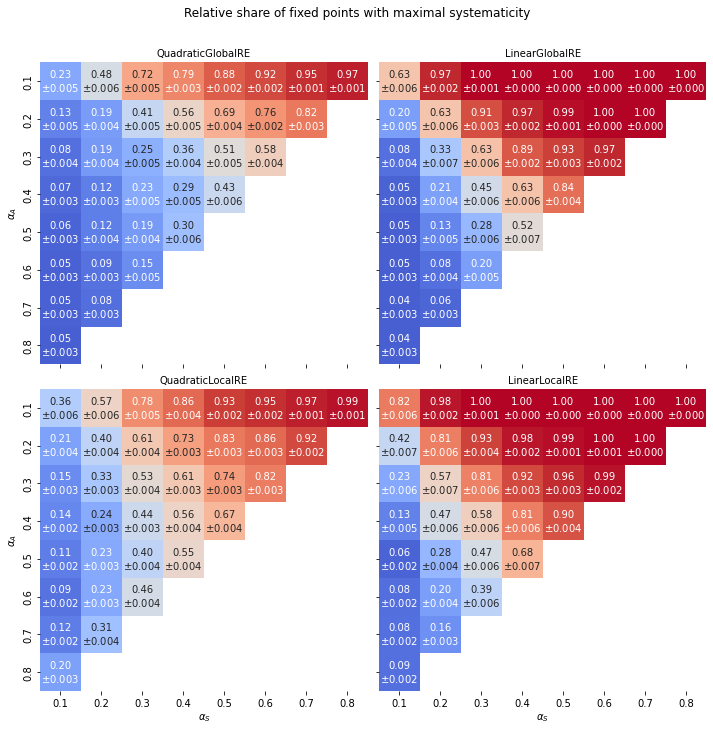

<Figure size 432x288 with 0 Axes>

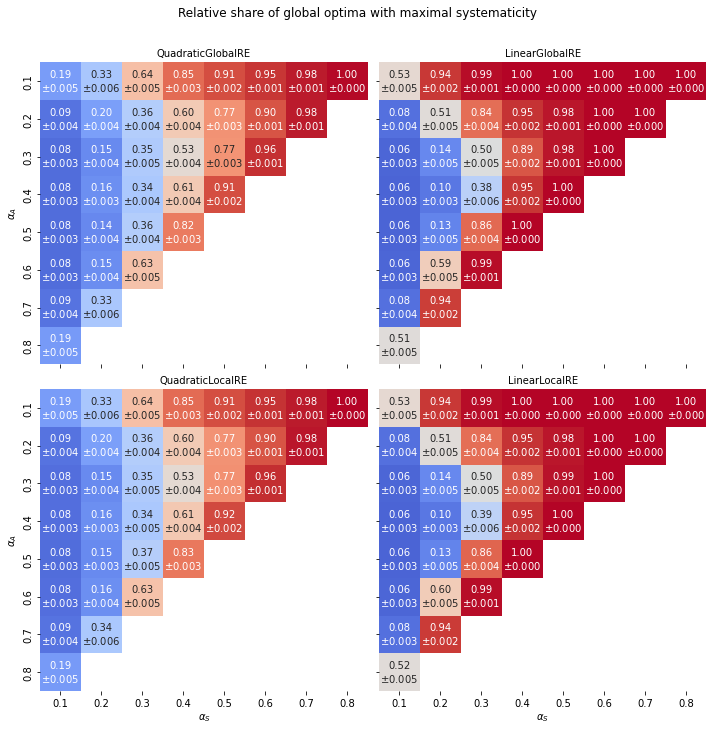

<Figure size 432x288 with 0 Axes>

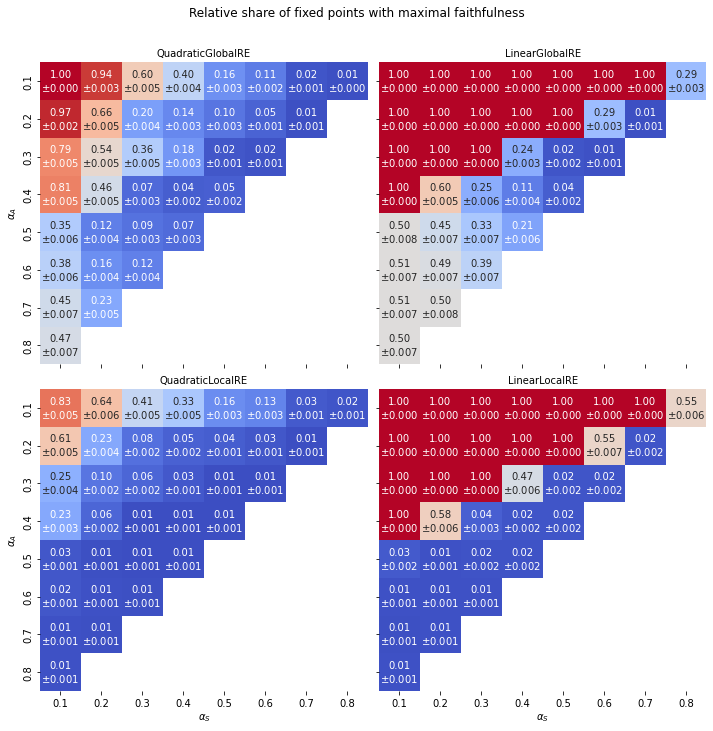

<Figure size 432x288 with 0 Axes>

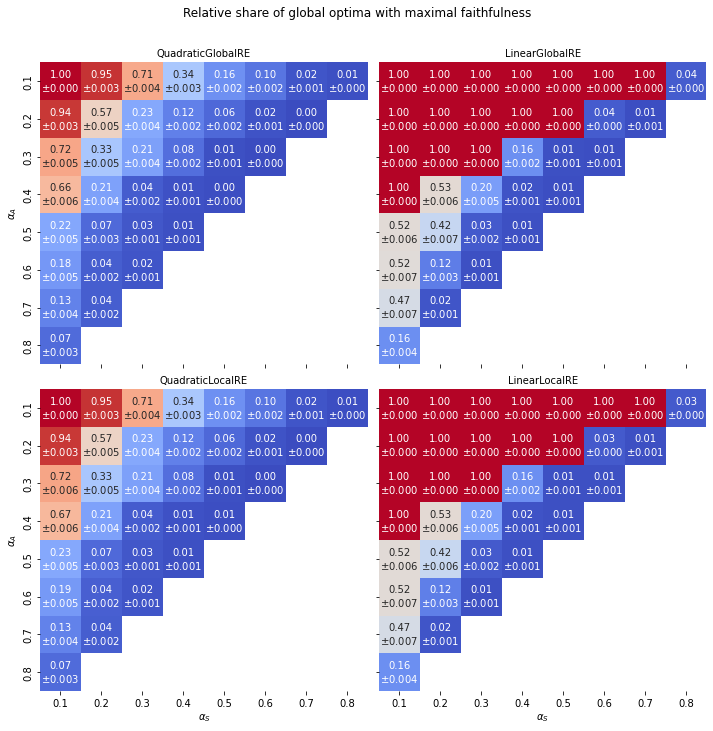

<Figure size 432x288 with 0 Axes>

In [97]:
for measure, endpoint_type in product(["account", "systematicity", "faithfulness"], ["fp", "go"]):
    
    df = exploded_go_data if endpoint_type == "go" else exploded_fp_data
    endpoint = "global optima" if endpoint_type == "go" else "fixed points"

    heat_maps_by_weights(re_data = df, 
                     values = "max_{}_{}".format(endpoint_type, measure), 
                     title = "Relative share of {} with maximal {}".format(endpoint, measure),
                     annot_std = True,
                     annot_fmt="{:2.2f}\n", 
                     annot_std_fmt = r'$\pm${:2.3f}',
                     vmin=0,
                     vmax=1,
                     bootstrap=bootstrap,
                     n_resamples=n_resamples)
    
    plt.show()

    branches = "branches" if analyse_branches else "setups"

    if export_results:
        plt.savefig(path.join(figures_output_dir, 'rel_{}_max_{}_{}.png'.format(endpoint_type, measure, branches)), bbox_inches='tight')